<a href="https://colab.research.google.com/github/DSGP-Group-1-EAPS/SL-Apparel-Dataset/blob/Ranidu-Gurusinghe/Time_Series_Forecasting_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas fbprophet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 20.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.8 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for fbprophet


In [10]:
from google.colab import drive
import pandas as pd

# Mounting the Google Drive
drive.mount('/content/drive')

# Load the preprocessed data
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/DSGP_COURSEWORK/SL Apparel Dataset model/preprocessed_data_new.xlsx', parse_dates=['Date'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# Group by 'Year', 'Month', then count the number of entries (leaves) for each group
monthly_leave_count = df.groupby(['Date', 'Code', 'LeaveYear', 'LeaveMonth']).size().reset_index(name='NumLeaves')

# Display the aggregated data
print(monthly_leave_count.tail())


            Date   Code  LeaveYear  LeaveMonth  NumLeaves
88742 2023-12-22  AA634       2023          12          1
88743 2023-12-22  AA715       2023          12          1
88744 2023-12-22  AA723       2023          12          1
88745 2023-12-22  AA761       2023          12          1
88746 2023-12-22  AA793       2023          12          1


In [31]:

# Function to calculate total leaves for the previous 2 months and average leaves
def calculate_previous_months_and_average(group):
    group['TotalLeavesPreviousMonth'] = group['NumLeaves'].shift(1)
    group['TotalLeavesPrevious2Months'] = group['NumLeaves'].shift(1) + group['NumLeaves'].shift(2)
    group['AverageLeaves'] = group['NumLeaves'].expanding().mean().shift(1)
    return group

# Apply the function within each group
monthly_leave_count = monthly_leave_count.groupby('Code').apply(calculate_previous_months_and_average)

# Fill NaN values with 0 for the first months
monthly_leave_count.fillna(0, inplace=True)

# Display the DataFrame with the new features
print(monthly_leave_count.tail())


<ipython-input-31-858fa1628030>:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  monthly_leave_count = monthly_leave_count.groupby('Code').apply(calculate_previous_months_and_average)


            Date   Code  LeaveYear  LeaveMonth  NumLeaves  \
88742 2023-12-22  AA634       2023          12          1   
88743 2023-12-22  AA715       2023          12          1   
88744 2023-12-22  AA723       2023          12          1   
88745 2023-12-22  AA761       2023          12          1   
88746 2023-12-22  AA793       2023          12          1   

       TotalLeavesPreviousMonth  TotalLeavesPrevious2Months  AverageLeaves  
88742                       1.0                         2.0       1.066667  
88743                       1.0                         2.0       1.057143  
88744                       1.0                         2.0       1.000000  
88745                       1.0                         2.0       1.034483  
88746                       1.0                         3.0       1.076923  


In [32]:


# Define the cutoff date for training (until 2022-12)
train_cutoff_date = pd.to_datetime('2022-12-31')

# Split the data into training and testing sets
train_data = monthly_leave_count[monthly_leave_count['Date'] <= train_cutoff_date]
test_data = monthly_leave_count[monthly_leave_count['Date'] > train_cutoff_date]

# Display the shapes of the training and testing sets
print("Training set shape:\n", train_data, "\n")
print("Testing set shape:\n", test_data.shape)


Training set shape:
             Date    Code  LeaveYear  LeaveMonth  NumLeaves  \
0     2021-12-01  AA1118       2021          12          1   
1     2021-12-01  AA1134       2021          12          1   
2     2021-12-01  AA1142       2021          12          1   
3     2021-12-01  AA1148       2021          12          1   
4     2021-12-01  AA1194       2021          12          1   
...          ...     ...        ...         ...        ...   
63144 2022-12-29   AA920       2022          12          1   
63145 2022-12-29   AA924       2022          12          1   
63146 2022-12-29   AA943       2022          12          1   
63147 2022-12-29   AA958       2022          12          1   
63148 2022-12-29   AA997       2022          12          1   

       TotalLeavesPreviousMonth  TotalLeavesPrevious2Months  AverageLeaves  
0                           0.0                         0.0       0.000000  
1                           0.0                         0.0       0.000000  
2  

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Features and target variable for training
X_train = train_data[['LeaveYear', 'LeaveMonth', 'TotalLeavesPreviousMonth', 'TotalLeavesPrevious2Months', 'AverageLeaves']]
y_train = train_data['NumLeaves']

# Features and target variable for testing
X_test = test_data[['LeaveYear', 'LeaveMonth', 'TotalLeavesPreviousMonth', 'TotalLeavesPrevious2Months', 'AverageLeaves']]
y_test = test_data['NumLeaves']

# Initialize the RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Accuracy: 97.96%

Confusion Matrix:
[[25055    59     0]
 [  456    22     0]
 [    6     0     0]]

Classification Report:
              precision    recall  f1-score   support

           1       0.98      1.00      0.99     25114
           2       0.27      0.05      0.08       478
           3       0.00      0.00      0.00         6

    accuracy                           0.98     25598
   macro avg       0.42      0.35      0.36     25598
weighted avg       0.97      0.98      0.97     25598



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will

Root Mean Squared Error (RMSE): 1.0801236811897013


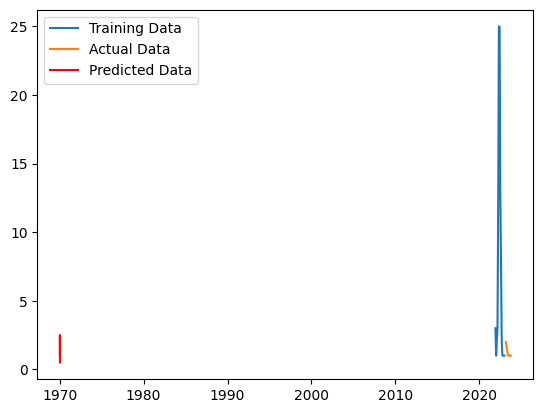

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

# Assuming 'Code' is the column containing employee codes
# Create new columns 'Year' and 'Month' to store the year and month of each entry
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Group by 'Code', 'Year', 'Month', then count the number of entries (leaves) for each group
monthly_leave_count = df.groupby(['Code', 'Year', 'Month']).size().reset_index(name='NumLeaves')

# Assuming 'Code' is the employee code you're interested in
employee_code = 'AA983'

# Filter data for the specific employee
employee_data = monthly_leave_count[monthly_leave_count['Code'] == employee_code]

# Create a time series for the number of leaves
time_series = pd.Series(employee_data['NumLeaves'].values, index=pd.to_datetime(employee_data[['Year', 'Month']].assign(day=1)))

# Split the time series into training and testing sets
train_size = int(len(time_series) * 0.8)
train, test = time_series[0:train_size], time_series[train_size:]

# Fit SARIMAX model
order = (1, 1, 1)  # You can adjust these parameters based on model performance
seasonal_order = (1, 1, 1, 12)
model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
result = model.fit(disp=False)

# Make predictions for the test set
predictions = result.get_forecast(steps=len(test))
predicted_values = predictions.predicted_mean

# Evaluate the model
rmse = sqrt(mean_squared_error(test, predicted_values))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Plot actual vs predicted values
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Data')
plt.plot(predicted_values, label='Predicted Data', color='red')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Root Mean Squared Error (RMSE): 1.0


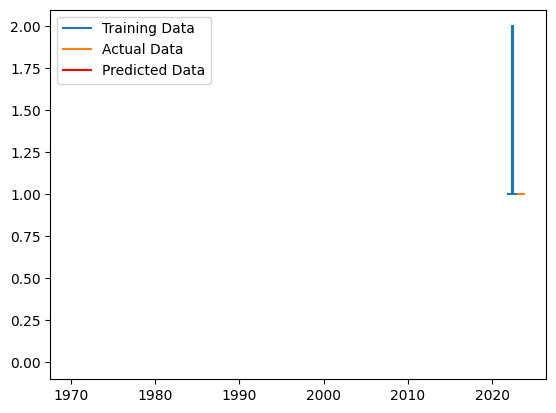

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

# Assuming 'Code' is the column containing employee codes
# Create new columns 'Year' and 'Month' to store the year and month of each entry
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Group by 'Code', 'Year', 'Month', then count the number of entries (leaves) for each group
monthly_leave_count = df.groupby(['Date','Code', 'Year', 'Month']).size().reset_index(name='NumLeaves')

# Assuming 'Code' is the employee code you're interested in
employee_code = 'AA983'

# Filter data for the specific employee
employee_data = monthly_leave_count[monthly_leave_count['Code'] == employee_code]

# Filter data for training until 2022-12-31
train_data = employee_data[employee_data['Date'] <= '2022-12-31']

# Create a time series for the number of leaves
time_series_train = pd.Series(train_data['NumLeaves'].values, index=pd.to_datetime(train_data[['Year', 'Month']].assign(day=1)))

# Filter data for testing from 2023-01-01 onwards
test_data = employee_data[employee_data['Date'] >= '2023-01-01']

# Create a time series for the number of leaves
time_series_test = pd.Series(test_data['NumLeaves'].values, index=pd.to_datetime(test_data[['Year', 'Month']].assign(day=1)))

# Fit SARIMAX model
order = (0, 0, 0)  # You can adjust these parameters based on model performance
seasonal_order = (0, 0, 0, 12)

model = SARIMAX(time_series_train, order=order, seasonal_order=seasonal_order)
result = model.fit(disp=False)

# Make predictions for the test set
predictions = result.get_forecast(steps=len(time_series_test))
predicted_values = predictions.predicted_mean

# Evaluate the model
rmse = sqrt(mean_squared_error(time_series_test, predicted_values))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Plot actual vs predicted values
plt.plot(time_series_train, label='Training Data')
plt.plot(time_series_test, label='Actual Data')
plt.plot(predicted_values, label='Predicted Data', color='red')
plt.legend()
plt.show()
